# Example 1: 2-D fault network extraction from a numerical model
This example describes how to extract a 2-D fault network from a numerical model simulating continental rifting. This example is based on the study of Naliboff et al. (2020).

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for: https://github.com/thilowrona/fatbox_tutorials/blob/main/1-fault_extraction/1_fault_extraction.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-edb2f99f
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-edb2f99f
     |████████████████████████████████| 163kB 6.9MB/s 
     |████████████████████████████████| 103.4MB 90kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-xjp3si1v/cv-algorithms
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-xjp3si1v/cv-algorithms
  Created wheel for fatbox: filename=fatbox-0.0.1-cp37-none-any.whl size=25833 sha256=fc9e1ad207b5afecda2ed1c51c91c3884213f7fcd7ab70b818ebc1dee92c691b
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8kymhid/wheels/3c/75/06/4f57a6a85e140ffdf1280b29ebde7d5e62277dfc68e4aeb466
  Created wheel for network: filename=network-0.1-cp37-none-any.whl size=3157 sha256=28073683f3bf79b4a00663433e5f91ce53858321bfcdc6e592400489c0de33df
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/7098

download the tutorials:

In [2]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 275 (delta 27), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (275/275), 29.96 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (98/98), done.


Now we can load the python packages that we need:

In [10]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
from fatbox.edits import label_components
from fatbox.plots import plot_components

## Fault extraction

First, we load our data - a strain rate map extracted just below the surface of the model:

In [7]:
strain_rate = np.load('/content/fatbox_tutorials/1-fault_extraction/NearSurfaceIsotherm_335K_strain_rate.npy')

Now we can plot it to look the faults in the model

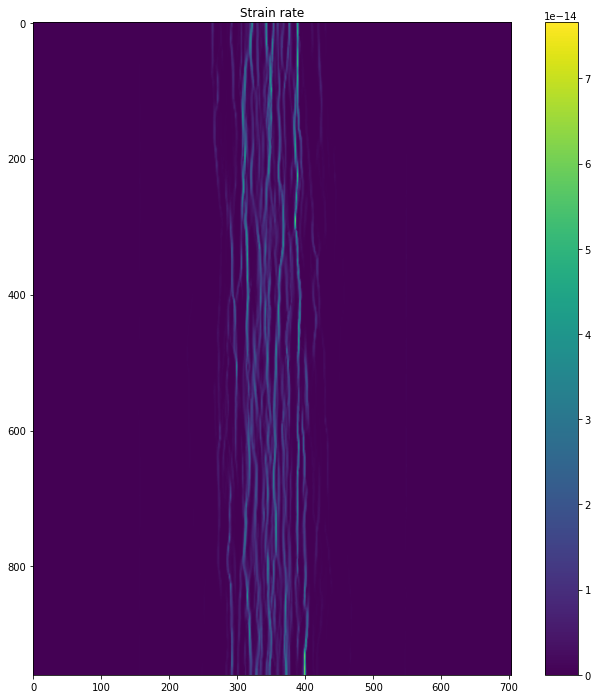

In [8]:
plt.figure(figsize=(12,12))
plt.title('Strain rate')
plt.imshow(strain_rate, vmin=0)
plt.colorbar()
plt.show()

Next we want to separate the faults from the background using a threshold:

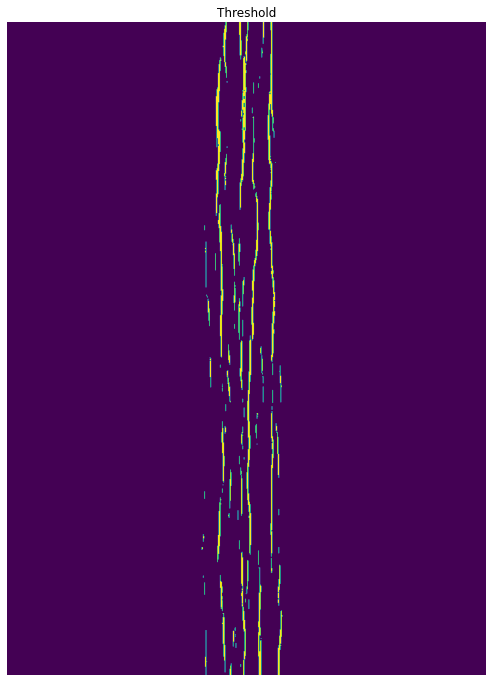

In [11]:
threshold = simple_threshold_binary(strain_rate, 1.5e-14)

plt.figure(figsize=(12,12))
plt.title('Threshold')
plt.imshow(threshold)
plt.axis('off')
plt.show()

Now we can reduce the areas above the threshold to lines using a skeletonize algorithm:

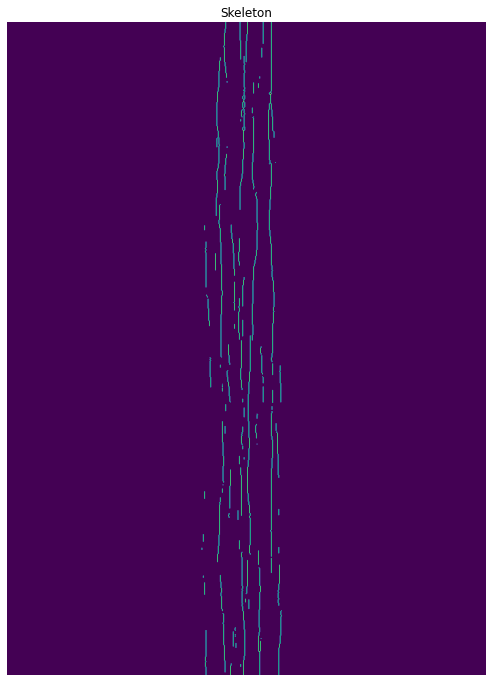

In [13]:
skeleton = skeleton_guo_hall(threshold)

plt.figure(figsize=(12,12))
plt.title('Skeleton')
plt.imshow(skeleton)
plt.axis('off')
plt.show()

Now we can convert these lines to points:

In [14]:
points = array_to_points(skeleton)

These points become the nodes of our graph G:

In [15]:
G = nx.Graph()

for node, point in enumerate(points):
    G.add_node(node)
    G.nodes[node]['pos'] = point

Remember a graph is an object consisting only of nodes and edges. Our graph for example looks like this:

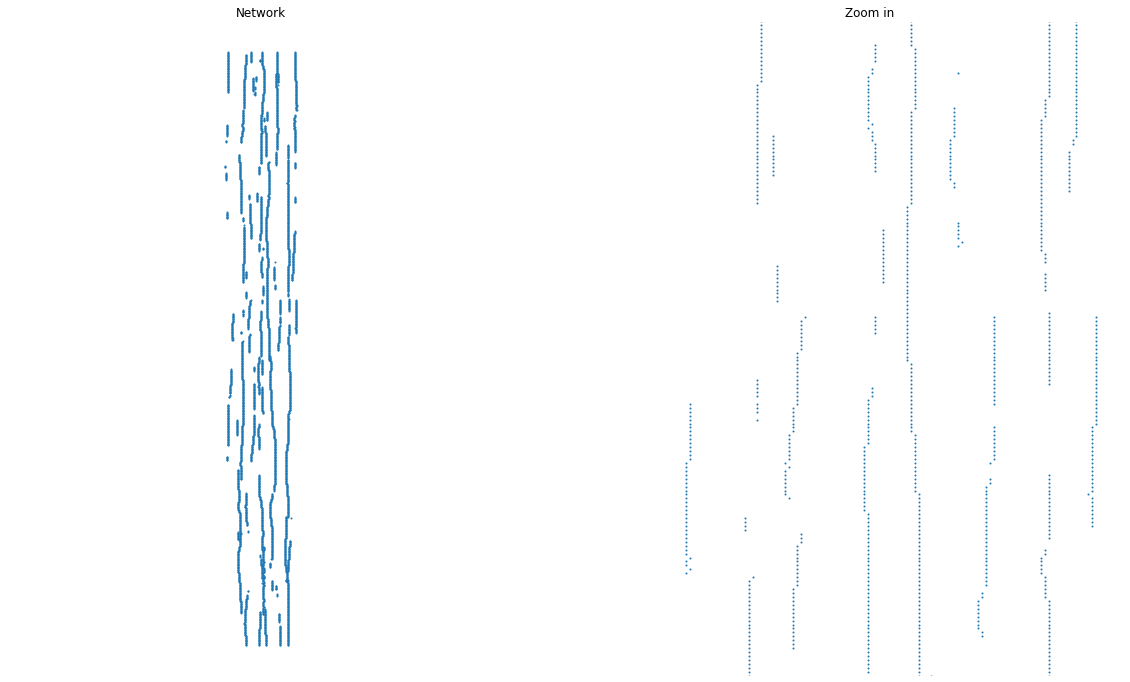

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20,12))

axs[0].set_title('Network')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')


axs[1].set_title('Zoom in')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_ylim([500, 600])

plt.show()

You can see that the graph only consists of closely spaced points, which are not yet connected. So let's change that!


We calculate the distance between all nodes in a distance matrix and connect the ones close to each other (<1.5 pixels away):

In [17]:
dm = distance_matrix(points, points) 

print(str(points.shape[0]) + ' Points')
for n in range(points.shape[0]):
    stdout.write("\r%d" % n)
    stdout.flush()
    for m in range(points.shape[0]):
        if dm[n,m]<1.5 and n != m:
            G.add_edge(n,m)

4797 Points
4796

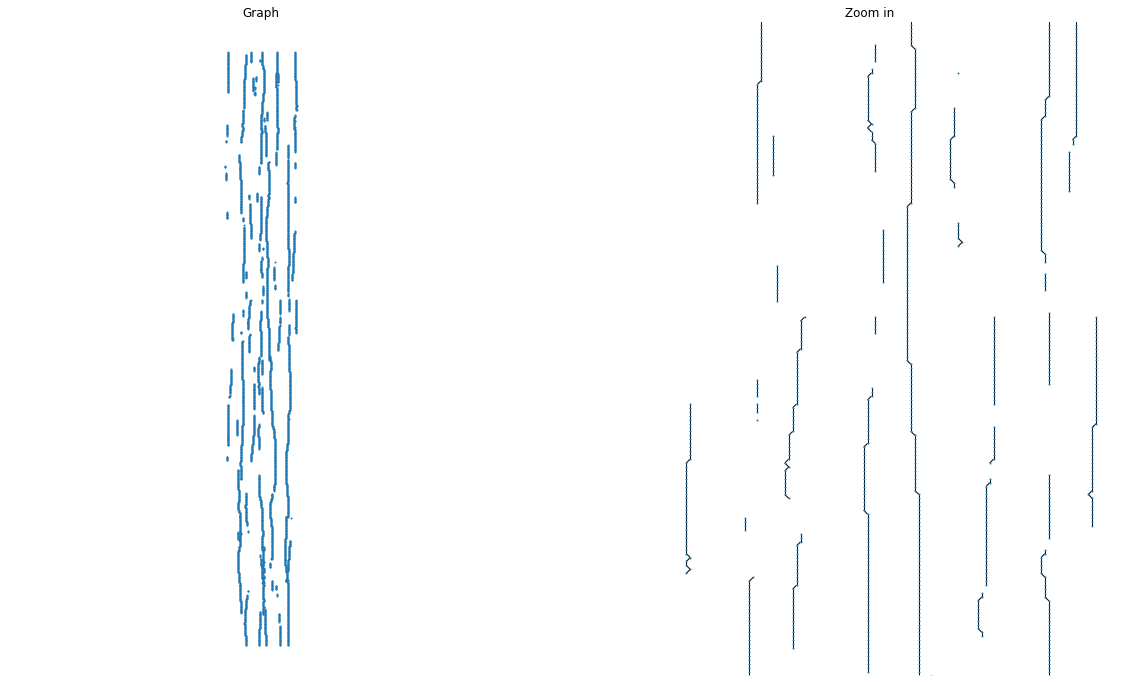

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20,12))

axs[0].set_title('Graph')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')


axs[1].set_title('Zoom in')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_ylim([500, 600])

plt.show()

Now we can see that neighboring nodes are connected by edges (black lines). This allows us to label the nodes connected to one another as components:

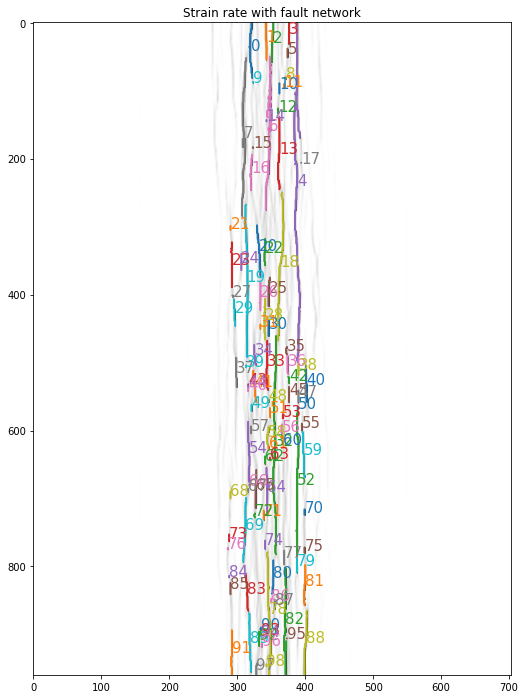

In [19]:
G = label_components(G)

fig, axs = plt.subplots(1, 1, figsize=(12,12))
axs.imshow(strain_rate, 'gray_r', vmin=0)
plot_components(G, axs, label=True)
plt.title('Strain rate with fault network')
plt.show()

When we zoom in, we can see the nodes colored by their component and the edges connecting them:

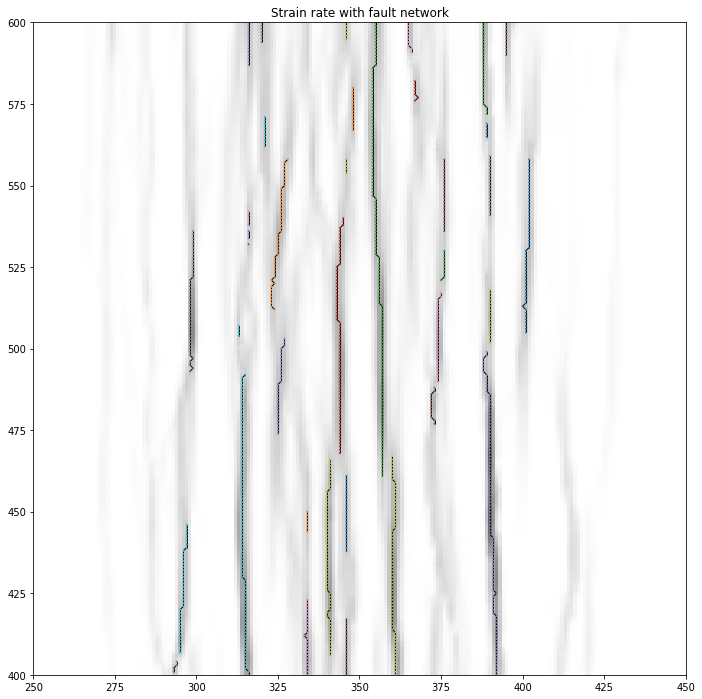

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(12,12))
axs.imshow(strain_rate, 'gray_r', vmin=0)
plot_components(G, axs, label=False)
axs.set_xlim([250, 450])
axs.set_ylim([400, 600])
plt.title('Strain rate with fault network')
plt.show()

## Structure of the network
Let's have a look at the structure of the fault network (or graph). Remember it only consists of nodes and edges. So let's have a look at the nodes:

In [21]:
print(G.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Okay, nothing special here, just a list of the nodes. Let's pick out one:

In [22]:
print(G.nodes[0])

{'pos': array([321.,   0.]), 'component': 0}


Alright, we can see the position of the node and the component it belongs to. Let's say we want to give it an extra property, e.g. the strain rate at its location:

In [23]:
G.nodes[0]['strain_rate'] = strain_rate[int(G.nodes[0]['pos'][0]), int(G.nodes[0]['pos'][1])]

In [24]:
print(G.nodes[0])

{'pos': array([321.,   0.]), 'component': 0, 'strain_rate': 3.7951648592283697e-17}


Nice! Let's do that for all nodes:

In [25]:
for node in G.nodes:
  G.nodes[node]['strain_rate'] = strain_rate[int(G.nodes[node]['pos'][1]), int(G.nodes[node]['pos'][0])]

and plot it:

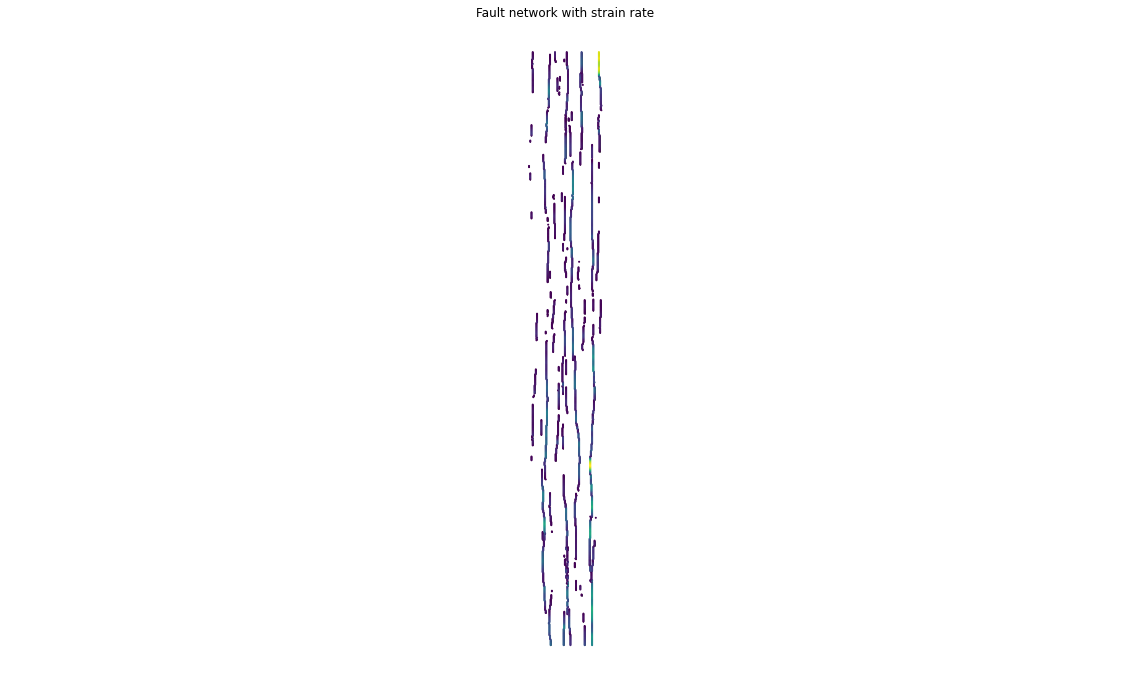

In [26]:
fig, ax = plt.subplots(figsize=(20,12))

ax.set_title('Fault network with strain rate')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        node_color = np.array([G.nodes[node]['strain_rate'] for node in G.nodes]), 
        node_size=1,
        ax=ax)
ax.axis('equal')
plt.show()

Like this we can compute and visualize all kinds of properties on the fault network.

But what about the edges?

In [27]:
print(G.edges)

[(0, 5), (1, 6), (2, 7), (3, 8), (4, 9), (5, 10), (6, 11), (7, 12), (8, 13), (9, 14), (10, 15), (11, 16), (12, 17), (13, 18), (14, 19), (15, 20), (16, 21), (17, 22), (18, 23), (19, 24), (20, 25), (21, 26), (22, 27), (23, 28), (24, 29), (25, 30), (26, 31), (27, 32), (28, 33), (29, 34), (30, 35), (31, 36), (32, 37), (33, 38), (34, 39), (35, 40), (36, 41), (37, 42), (38, 43), (39, 44), (40, 45), (41, 46), (42, 47), (43, 48), (44, 49), (45, 50), (46, 51), (47, 52), (48, 53), (49, 54), (50, 55), (51, 56), (52, 57), (53, 58), (54, 59), (55, 60), (56, 61), (57, 62), (58, 63), (59, 64), (60, 65), (61, 66), (62, 67), (63, 68), (64, 69), (65, 70), (66, 71), (67, 72), (68, 73), (69, 74), (70, 75), (71, 76), (72, 77), (73, 78), (74, 79), (75, 80), (76, 81), (77, 82), (78, 83), (79, 84), (80, 85), (81, 86), (82, 87), (83, 88), (84, 89), (85, 90), (86, 91), (87, 92), (88, 93), (89, 94), (90, 95), (91, 96), (92, 97), (93, 98), (94, 99), (95, 100), (96, 101), (97, 102), (98, 103), (99, 104), (100, 105

Alright, just tuples of nodes. Let's pick one:

In [28]:
print(G.edges[(0, 5)])

{}


Okay, they have no property yet. Let's calculate its length:

In [29]:
edge = (0, 5)
G.edges[edge]['length'] = np.linalg.norm(G.nodes[edge[0]]['pos']-G.nodes[edge[1]]['pos'])

In [30]:
print(G.edges[(0, 5)])

{'length': 1.0}


Again, we can do this for all edges:

In [31]:
for edge in G.edges:
  G.edges[edge]['length'] = np.linalg.norm(G.nodes[edge[0]]['pos']-G.nodes[edge[1]]['pos'])

and plot it:

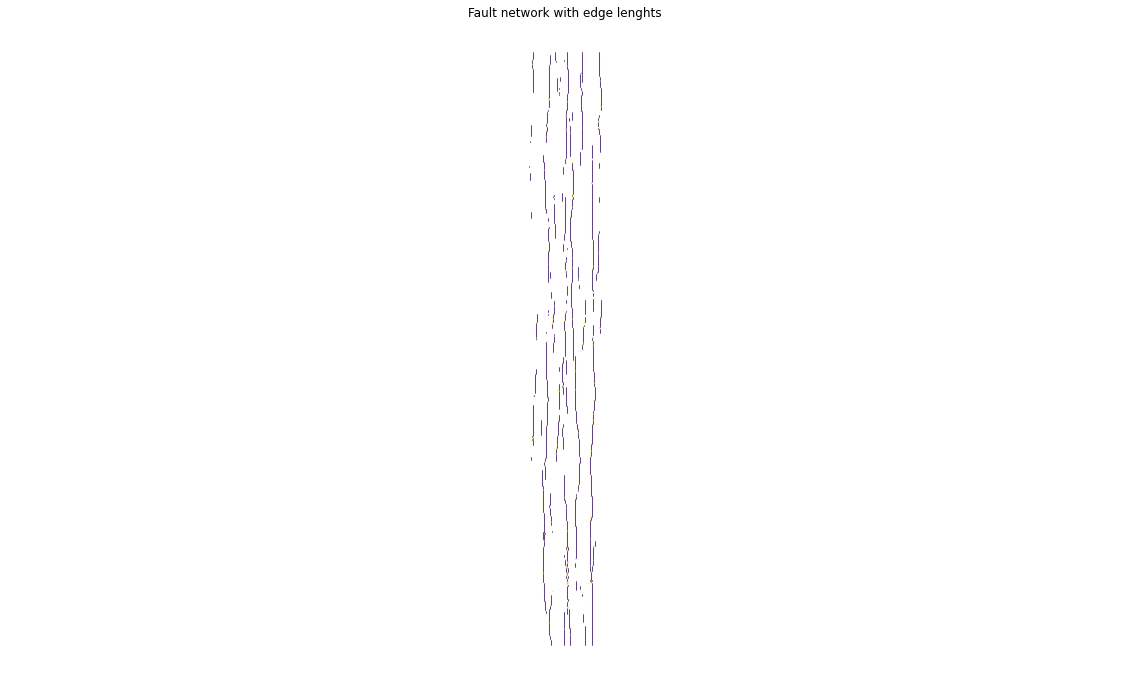

In [32]:
fig, ax = plt.subplots(figsize=(20,12))

ax.set_title('Fault network with edge lenghts')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        edge_color = np.array([G.edges[edge]['length'] for edge in G.edges]), 
        node_size=0.001,
        ax=ax)
ax.axis('equal')
plt.show()

Awesome! That's it. You've extracted your first fault network. In the next tutorial, we will learn how to compute and visualize fault strikes:
https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb 